### About
- This notebook summarize the following datasets.
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [2]:
import os
import numpy as np
from pathlib import Path
import re
from imageio import imread
from skimage import transform
import shutil
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import random
from IPython.core.pylabtools import figsize

%matplotlib inline

### Split samples
- 590 samples in total
    - 400 for training
    - 190 for validation

In [3]:
data_dir = Path('../../../data/nyu_depth_v2_raw')
samples = os.listdir(data_dir)
print('Number of sampels: ', len(samples))

Number of sampels:  590


### Example room

In [5]:
sample = 'living_room_0044'
files = os.listdir(data_dir / sample)

pgms = [f for f in files if '.pgm' in f and 'd-' in f]
ppms = [f for f in files if '.ppm' in f and 'r-' in f]

print('number of pgms: ', len(pgms), 'number of ppms: ', len(ppms))

number of pgms:  445 number of ppms:  445


### Read .pgm images
- Reference
    - https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm

In [11]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

### Depth image sample
- .pgm format
- filename with prefix d-

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


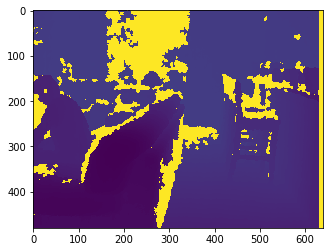

[[1010 1010 1010 ... 2047 2047 2047]
 [1010 1010 1010 ... 2047 2047 2047]
 [1010 1010 1010 ... 2047 2047 2047]
 ...
 [ 837  837  837 ... 2047 2047 2047]
 [ 837  837  837 ... 2047 2047 2047]
 [ 837  837  837 ... 2047 2047 2047]]
image shape resized:  (74, 55) image type:  <class 'numpy.ndarray'>


/home/dushu/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dushu/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


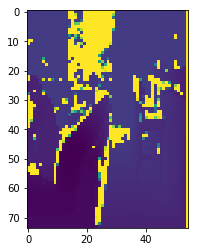

[[0.01543852 0.01551381 0.01554456 ... 0.01542687 0.01545296 0.03123522]
 [0.01546224 0.01551843 0.01557946 ... 0.01541856 0.01544213 0.03123522]
 [0.01548791 0.01553368 0.01557044 ... 0.01542687 0.01542756 0.03123522]
 ...
 [0.01279054 0.01281688 0.01282382 ... 0.01418465 0.01409864 0.03123522]
 [0.01278332 0.01279057 0.01282382 ... 0.0141777  0.0140988  0.03123522]
 [0.01278831 0.01283284 0.01283908 ... 0.01412754 0.01408338 0.03123522]]


In [57]:
for pgm in pgms[:1]:
    image = read_pgm(data_dir / sample / pgm, byteorder='<')
    print('image shape: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    print(image)
    
    image = transform.resize(image, (74, 55))
    print('image shape resized: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    print(image)

### RGB image sample
- .ppm format
- filename with prefix r-

image shape:  (480, 640, 3) image type:  <class 'numpy.ndarray'>


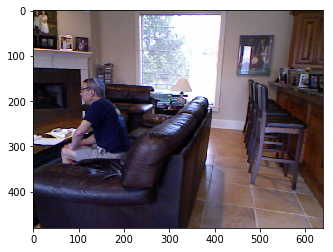

image shape resized:  (304, 228, 3) image type:  <class 'numpy.ndarray'>


/home/dushu/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dushu/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


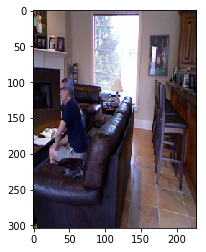

image shape resized:  (74, 55, 3) image type:  <class 'numpy.ndarray'>


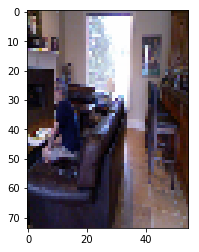

In [53]:
for ppm in ppms[:1]:
    image = imread(data_dir / sample / ppm)
    image = np.array(image)
    print('image shape: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    image = transform.resize(image, (304,  228))
    print('image shape resized: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    image = transform.resize(image, (74, 55))
    print('image shape resized: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()

### Split train/valid data

In [129]:
train_rgb = Path('./data/train/rgb')
train_depth = Path('./data/train/depth')

valid_rgb = Path('./data/valid/rgb')
valid_depth = Path('./data/valid/depth')

if os.path.exists(train_rgb) or os.path.exists(train_depth):
    shutil.rmtree(train_rgb)
    shutil.rmtree(train_depth)
os.makedirs(train_rgb)
os.makedirs(train_depth)

if os.path.exists(valid_rgb) or os.path.exists(valid_depth):
    shutil.rmtree(valid_rgb)
    shutil.rmtree(valid_depth)
os.makedirs(valid_rgb)
os.makedirs(valid_depth)

In [130]:
num_train = 400
num_train_real = 0
idx = 0
ss = []
for i, s in enumerate(samples):    
    
    rgb_samples = [f for f in os.listdir(data_dir / s) if '.ppm' in f and 'r-' in f]
    depth_samples = [f for f in os.listdir(data_dir / s) if '.pgm' in f and 'd-' in f]
    
    if abs(len(rgb_samples) - len(depth_samples)) > 10:
        ss.append(s)

    if not rgb_samples or not depth_samples:
        print('Empty folder: ', i, s)
        continue
    else:
        rgb_sample, depth_sample = rgb_samples[0], depth_samples[0]
    
    if i < num_train:
        shutil.copyfile(data_dir / s / rgb_sample, train_rgb / '{}.ppm'.format(idx))
        shutil.copyfile(data_dir / s / depth_sample, train_depth / '{}.pgm'.format(idx))
        num_train_real += 1
    else:
        shutil.copyfile(data_dir / s / rgb_sample, valid_rgb / '{}.ppm'.format(idx - num_train_real))
        shutil.copyfile(data_dir / s / depth_sample, valid_depth / '{}.pgm'.format(idx - num_train_real))
    
    idx += 1

print('finished')
print(len(ss))

bathroom_0035
bedroom_0002
bedroom_0024
bedroom_0029
bedroom_0030
bedroom_0031
bedroom_0045
bedroom_0051
bedroom_0079
bedroom_0080
bedroom_0081
bedroom_0117
bedroom_0119
bedroom_0121
bookstore_0001m
classroom_0006
dentist_office_0002
dinette_0001
dining_room_0002
dining_room_0010
dining_room_0018
dining_room_0025
dining_room_0029
dining_room_0030
dining_room_0035
dining_room_0036
furniture_store_0001d
furniture_store_0001g
home_office_0001
home_office_0003
home_office_0008
kitchen_0001a
kitchen_0001b
Empty folder:  347 kitchen_0018a
Empty folder:  348 kitchen_0018b
Empty folder:  349 kitchen_0018c
kitchen_0021
kitchen_0022
kitchen_0024
kitchen_0030a
kitchen_0033
kitchen_0035b
kitchen_0037
kitchen_0041
kitchen_0042
kitchen_0050
library_0001a
library_0001b
library_0002a
library_0002b
library_0003
library_0007
library_0008
living_room_0001a
living_room_0001c
Empty folder:  438 living_room_0023a
Empty folder:  439 living_room_0023b
Empty folder:  440 living_room_0024a
Empty folder:  441 li

In [132]:
shutil.copyfile(valid_rgb / '68.ppm', valid_rgb / '67.ppm')
shutil.copyfile(valid_depth / '68.pgm', valid_depth / '67.pgm')

PosixPath('data/valid/depth/67.pgm')

seed:  970255495
torch.Size([480, 640])


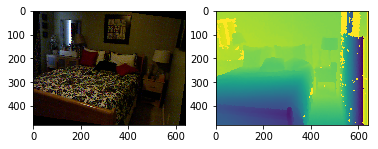

In [4]:
a = Image.open('./data/train/rgb/155.ppm')
b = Image.open('./data/train/depth/155.pgm')

s = random.randint(0, 2 ** 32)
print('seed: ', s)
random.seed(s)
a = transforms.RandomRotation(50)(a)

random.seed(s)
#b = transforms.RandomRotation(50)(b)

plt.subplot(121)
plt.imshow(a)

b = transforms.ToTensor()(b).view(480, 640)
print(b.size())
plt.subplot(122)
plt.imshow(b)

plt.show()

[[[ 4 35  1]
  [ 4 34  9]
  [13 35 18]
  ...
  [ 2  1  1]
  [ 1  1  1]
  [ 1  1  1]]

 [[12 32  1]
  [12 33  9]
  [21 30 18]
  ...
  [ 2  1  1]
  [ 1  1  1]
  [ 1  2  1]]

 [[21 30  7]
  [21 28 19]
  [30 25 32]
  ...
  [ 2  1  1]
  [ 1  1  1]
  [ 1  1  1]]

 ...

 [[22  5  1]
  [22  4  1]
  [23  5  1]
  ...
  [53 33  1]
  [47 33  1]
  [42 34  1]]

 [[21  7  1]
  [21  4  1]
  [19  5  1]
  ...
  [47 35  1]
  [41 34  1]
  [36 35  1]]

 [[21  4  2]
  [21  2  1]
  [19  5  1]
  ...
  [47 34  1]
  [41 35  1]
  [36 38  1]]]


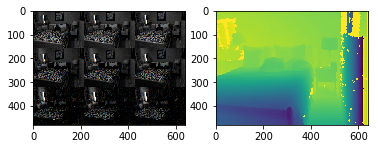

In [18]:
a = Image.open('./data/train/rgb/155.ppm')
b = Image.open('./data/train/depth/155.pgm')

print(np.asarray(a))
a = transforms.ToTensor()(a).view(480, 640, 3)
plt.subplot(121)
plt.imshow(a)

b = transforms.ToTensor()(b).view(480, 640)
plt.subplot(122)
plt.imshow(b)

([array([5., 4., 3., 2., 5., 1., 4., 2., 1., 3.]),
  array([5., 1., 2., 3., 1., 5., 4., 3., 2., 4.]),
  array([4., 5., 1., 5., 0., 1., 3., 6., 4., 1.]),
  array([9., 2., 4., 4., 2., 2., 3., 1., 1., 2.]),
  array([2., 3., 2., 7., 3., 2., 2., 6., 1., 2.]),
  array([5., 2., 5., 2., 2., 1., 2., 6., 4., 1.]),
  array([2., 2., 0., 3., 6., 4., 3., 4., 1., 5.]),
  array([3., 2., 2., 2., 3., 2., 1., 4., 4., 7.]),
  array([2., 2., 6., 5., 3., 3., 1., 2., 3., 3.]),
  array([4., 3., 7., 3., 0., 2., 3., 2., 3., 3.]),
  array([2., 3., 3., 4., 1., 2., 3., 4., 4., 4.]),
  array([4., 3., 3., 3., 3., 2., 3., 2., 3., 4.]),
  array([3., 0., 2., 2., 4., 3., 2., 4., 7., 3.]),
  array([2., 4., 3., 1., 2., 2., 4., 6., 4., 2.]),
  array([1., 1., 2., 4., 4., 1., 1., 4., 9., 3.]),
  array([1., 4., 3., 2., 4., 2., 4., 6., 1., 3.]),
  array([2., 4., 3., 2., 5., 4., 5., 1., 1., 3.]),
  array([4., 3., 4., 0., 5., 1., 3., 4., 4., 2.]),
  array([5., 3., 1., 0., 4., 5., 6., 4., 2., 0.]),
  array([4., 6., 4., 3., 2., 5.

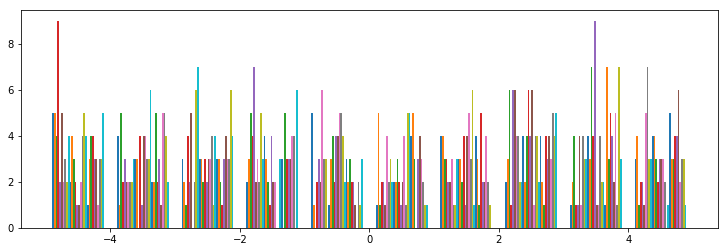

In [58]:
a = torch.randn((30, 30))
b = torch.randn((3, 3))
a[1, 2] = 0
a[1, 1] = 0
b[1, 1] = 0
a.uniform_(-5, 5)
plt.hist(a)

In [53]:
ma = (a == a.max())
mb = (b == b.min())
print(ma)
print(mb)

m = ma | mb
print(m)
print(~m)

tensor([[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 1, 0]], dtype=torch.uint8)
tensor([[1, 0, 0],
        [0, 0, 0],
        [0, 1, 0]], dtype=torch.uint8)
tensor([[0, 1, 1],
        [1, 1, 1],
        [1, 0, 1]], dtype=torch.uint8)


In [144]:
p = Path('../../../data')
pp = p / 'nyu_depth_v2_aligned'

ll = os.listdir(p / 'nyu_depth_v2_aligned')
print(len(ll))

if os.path.exists(p / 'train'):
    shutil.rmtree(p / 'train')
os.makedirs(p / 'train')

if os.path.exists(p / 'valid'):
    shutil.rmtree(p / 'valid')
os.makedirs(p / 'valid')

train_fi = 0
valid_fi = 0
for i, s in enumerate(ll):
    
    if i < 400:
        op = p / 'train'
    else:
        op = p / 'valid'
    
    print('>', end=' ')
    
    for fi in range(int(len(os.listdir(pp / s)) / 2)):
        
        if i < 400:
            shutil.move(pp / s / '{}.ppm'.format(fi), op / '{}.ppm'.format(train_fi))
            shutil.move(pp / s / '{}.pgm'.format(fi), op / '{}.pgm'.format(train_fi))
            train_fi += 1
        else:
            shutil.move(pp / s / '{}.ppm'.format(fi), op / '{}.ppm'.format(valid_fi))
            shutil.move(pp / s / '{}.pgm'.format(fi), op / '{}.pgm'.format(valid_fi))
            valid_fi += 1
    

510
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

### Move train/valid data

In [67]:
p0 = Path('../../../data/nyu_depth_v2_aligned')
pt0 = p0 / 'train'
pv0 = p0 / 'valid'

p1 = Path('../../../data/nyu')
pt1 = p1 / 'train'
pv1 = p1 / 'valid'

def move_files(pt0, pt1, t):
    
    i, j = 0, 0
    while os.path.exists(pt0 / 'rgb' / '{}.ppm'.format(i)):
        
        if os.path.getsize(pt0 / 'rgb' / '{}.ppm'.format(i)) > 0 and \
           os.path.getsize(pt0 / 'depth' / '{}.pgm'.format(i)) > 0:
            shutil.move(pt0 / 'rgb' / '{}.ppm'.format(i), pt1 / 'rgb' / '{}.ppm'.format(j))
            shutil.move(pt0 / 'depth' / '{}.pgm'.format(i), pt1 / 'depth' / '{}.pgm'.format(j))
            j += 1
        i += 1
    print(i, j)

move_files(pt0, pt1, 0)
move_files(pv0, pv1, 3)

343585 172236
97707 130


In [31]:
p0 = Path('../../../data/nyu_depth_v2_aligned')
ps = os.listdir(p0)

p1 = Path('../../../data/nyu')
pt1 = p1 / 'train'
pv1 = p1 / 'valid'

def move_files(pt0, pt1, begin=0, end=len(ps)):
    
    j = 0
    for k, s in enumerate(ps):
        
        if k not in range(begin, end):
            continue
        
        i = 0
        while os.path.exists(p0 / s / '{}.ppm'.format(i)):

            if os.path.getsize(p0 / s / '{}.ppm'.format(i)) > 0 and \
               os.path.getsize(p0 / s / '{}.pgm'.format(i)) > 0:
                shutil.move(p0 / s / '{}.ppm'.format(i), pt1 / 'rgb' / '{}.ppm'.format(j))
                shutil.move(p0 / s / '{}.pgm'.format(i), pt1 / 'depth' / '{}.pgm'.format(j))
                j += 1
            i += 1
    print(j)

move_files(p0, pt1, end=400)
move_files(p0, pv1, begin=400)

280613
69336


In [32]:
n = 100

p0 = Path('../../../data/nyu/valid')
p1 = Path('../../../data/nyu/valid_')

for i in range(n):
    shutil.copyfile(p0 / 'rgb' / '{}.ppm'.format(i), p1 / 'rgb' / '{}.ppm'.format(i))
    shutil.copyfile(p0 / 'depth' / '{}.pgm'.format(i), p1 / 'depth' / '{}.pgm'.format(i))

### Statistics of data

In [16]:
p = Path('../../../data/nyu_depth_v2_aligned')

ns = []
n1000 = 0
for s in os.listdir(p):
    r = [f for f in os.listdir(p / s) if '.ppm' in f]
    #d = [f for f in os.listdir(p / s) if '.pgm' in f]
    
    if len(r) == 1000:
        n1000 += 1
     
    ns.append(len(r))
n1000

171

total number of scenes:  509
train:  280617
valid:  69339


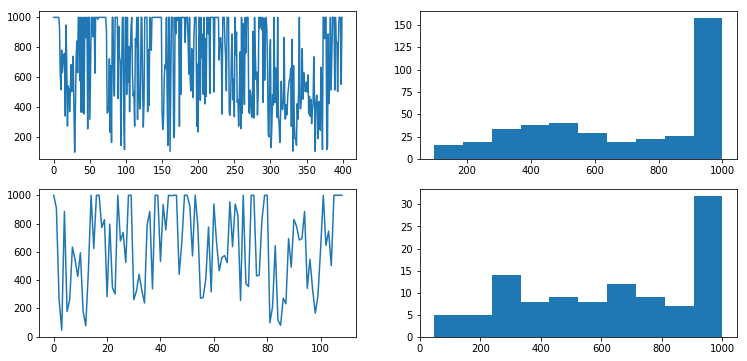

In [26]:
figsize(12.5, 6)

plt.subplot(221)
plt.plot(ns[:400])

plt.subplot(222)
plt.hist(ns[:400], bins=10)

plt.subplot(223)
plt.plot(ns[400:])

plt.subplot(224)
plt.hist(ns[400:], bins=10)

print('total number of scenes: ', len(ns))
print('train: ', np.sum(ns[:400]))
print('valid: ', np.sum(ns[400:]))

In [15]:
p0 = Path('../../../data/nyu_depth_v2_aligned/bookstore_0001d')
p1 = Path('../../../data/nyu/train')
p1_r = p1 / 'rgb'
p1_d = p1 / 'depth'

i = 0
while os.path.exists(p0 / '{}.ppm'.format(i)):
    shutil.copy(p0 / '{}.ppm'.format(i), p1_r / '{}.ppm'.format(i))
    shutil.copy(p0 / '{}.pgm'.format(i), p1_d / '{}.pgm'.format(i))
    i += 1